In [15]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

import matplotlib.pyplot as plt

In [16]:
data = pd.read_csv("../data/cleaned_data.csv", index_col=0, parse_dates=True)

In [17]:
train_end = "2015-12-31"

train_df = data.loc[:train_end]
test_df = data.loc[train_end:]

In [18]:
scaler = StandardScaler()
scaler.fit(train_df)

train_scaled = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

In [19]:
WINDOW_SIZE = 2

def create_sequences(df, window_size=WINDOW_SIZE):
    X, y = [], []
    values = df.values
    for i in range(len(df) - window_size):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size, 0])  # GDP growth is first column
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (141, 2, 5)
y_train shape: (141,)
X_test shape: (31, 2, 5)
y_test shape: (31,)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

In [21]:
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Predict next-quarter GDP growth
])

model.compile(optimizer=Adam(0.001), loss=Huber(delta=1.0))
model.summary()

/home/erikj/gdp-prediction/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2
)

Epoch 1/100


18/18 - 2s - 91ms/step - loss: 0.3556 - val_loss: 0.8903
Epoch 2/100
18/18 - 0s - 9ms/step - loss: 0.3306 - val_loss: 0.9028
Epoch 3/100
18/18 - 0s - 8ms/step - loss: 0.3163 - val_loss: 0.9184
Epoch 4/100
18/18 - 0s - 7ms/step - loss: 0.3056 - val_loss: 0.9268
Epoch 5/100
18/18 - 0s - 7ms/step - loss: 0.2992 - val_loss: 0.9477
Epoch 6/100
18/18 - 0s - 7ms/step - loss: 0.2926 - val_loss: 0.9441
Epoch 7/100
18/18 - 0s - 7ms/step - loss: 0.2892 - val_loss: 0.9498
Epoch 8/100
18/18 - 0s - 7ms/step - loss: 0.2859 - val_loss: 0.9541
Epoch 9/100
18/18 - 0s - 8ms/step - loss: 0.2840 - val_loss: 0.9509
Epoch 10/100
18/18 - 0s - 7ms/step - loss: 0.2815 - val_loss: 0.9503
Epoch 11/100
18/18 - 0s - 6ms/step - loss: 0.2798 - val_loss: 0.9548
Epoch 12/100
18/18 - 0s - 6ms/step - loss: 0.2784 - val_loss: 0.9522
Epoch 13/100
18/18 - 0s - 6ms/step - loss: 0.2775 - val_loss: 0.9603
Epoch 14/100
18/18 - 0s - 6ms/step - loss: 0.2768 - val_loss: 0.9513
Epoch 15/100
18/18 - 0s - 6ms/step - loss: 0.2756 - va

In [23]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


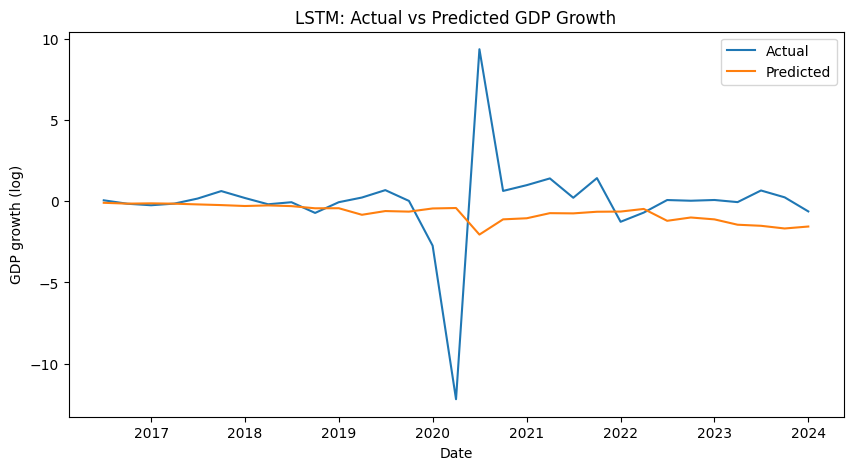

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(test_scaled.index[WINDOW_SIZE:], y_test, label="Actual")
plt.plot(test_scaled.index[WINDOW_SIZE:], y_pred, label="Predicted")
plt.xlabel("Date")
plt.ylabel("GDP growth (log)")
plt.title("LSTM: Actual vs Predicted GDP Growth")
plt.legend()
plt.show()